# Machine-Learning Ciphertext Decryption Algorithm

**Overview:** In this project, I implemented a machine-learning decryption algorithm that builds a multi-class support vector machine classification model to decrypt ciphertexts, encrypted with some randomly generated mixed-ciphertext alphabet.

## 1. Import all the necessary modules

**Briefly:** *string* library provides useful string operations, *numpy* provides support for arrays and mathematical operations, *random* provides tools for generating random numbers, and *collections* provides additional data structures like lists and dictionaries. Additionally, *SVC* class from *sklearn.svm* library is imported to provide support for support vector classification, *accuracy_score* function from *sklearn.metrics* library is imported to evaluate the accuracy of the classifier and finally, *defaultdict* class from *collections* is imported to provide a default value for nonexistent keys in dictionaries.

In [1]:
import string
import textwrap
import numpy as np
import random as rand
import collections as col
from sklearn.svm import SVC
from collections import defaultdict as dd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## 2. Implement manual feature extraction
Identify and describe the most common features that define the internal structure of the dataset: since the datasets in this problem are text files, letters are the ones that form the core of this internal structure. I extracted therefore, features related with the way these letters behave inside words and sentences.

**2.1. Single Letter Frequencies:** Calculates the number of times a single letter appears in the text and divides it by the total number of letters (*NL*). Then stores this frequency value in a dictionary (*feature_FR*) for later use.

- **Step.1:** The code creates an empty dictionary with keys derived from the *alphabet* and sets their initial values to 0.
- **Step.2:** It iterates through all the letters in *letters*. If there exists some letter which is also in the *alphabet*, it increments its value in *feature_FR* by 1 divided by the length of *letters*.
- **Step.3:** It calls *round_dict* function to round the values of the dictionary to the desired *accuracy*.
- **Step.4:** The frequency dictionary is returned as the result of the function.

In [2]:
def extract_feature_FR(alphabet, letters, NL, accuracy):
    feature_FR = dict.fromkeys(alphabet, 0)
    for l in letters:
        if l in alphabet:
            feature_FR[l] += 1/NL
    round_dict(feature_FR, accuracy)
    return feature_FR

**2.2. Letter Occurencies in k-letter words:** Calculates the number of times a letter appears in a k-letter word (*word_length*: k = 1,2,...) and divides it by the total number of its occurencies inside the text (*letters_times*). Then stores this frequency value in a dictionary (*feature_WL*) for later use.
- **Step.1:** The code creates an empty dictionary with keys derived from the *alphabet* and sets their initial values to 0.
- **Step.2:** For each k-letter word in *words*, where k>1, it iterates through all its letters. If there exists some letter which is also in the *alphabet*, it increments its value in *feature_WL* by 1 divided by its corresponding value in *letters-times*. In the special case where k=1, the values of these letters are set to 1 - binary representation "positive:1" and "negative:0".
- **Step.3:** It calls *round_dict* function to round the values of the dictionary to the desired *accuracy*.
- **Step.4:** The frequency dictionary is returned as the result of the function.

In [3]:
def extract_feature_WL(alphabet, words, word_length, letters_times, accuracy):
    feature_WL = dict.fromkeys(alphabet, 0)
    for w in words:
        if word_length == 1 and len(w) == word_length and w in alphabet:
            feature_WL[w] = 1
        elif (has_domain(word_length, 2, 4) and len(w) == word_length) or \
             (has_domain(word_length, 5, 7) and has_domain(len(w), 5, 7)) or \
             (has_domain(word_length, 8, 10) and has_domain(len(w), 8, 10)) or \
             (word_length > 10 and len(w) >= word_length):
            for l in list(w):
                if l in alphabet:
                    feature_WL[l] += 1/letters_times.get(l)
    round_dict(feature_WL, accuracy)
    return feature_WL

**2.3. Letter Position Frequencies:** Calculates the number of times a letter appears in the beginning/ending (or both) of words and divides it by the total number of its occurencies inside the text (*letters_times*). Then stores this frequency value in a dictionary (*feature_LP*) for later use.
- **Step.1:** The code creates an empty dictionary with keys derived from the *alphabet* and sets their initial values to 0.
- **Step.2:** For each word in *words*, it extracts its *first* and *last* letter.
- **Step.3:** If *first* and *last* are in the *alphabet*, it increments their value in *feature_LP* by 1 divided by their corresponding values in *letters-times*. The *case* argument determines which letters of the word should be counted: first, last, those that are both first and last.
- **Step.4:** It calls *round_dict* function to round the values of the dictionary to the desired *accuracy*.
- **Step.5:** The frequency dictionary is returned as the result of the function.

In [4]:
def extract_feature_LP(alphabet, case, words, letters_times, accuracy):
    feature_LP = dict.fromkeys(alphabet, 0)
    for w in words:
        first = list(w)[0]
        last = list(w)[len(w)-1]
        if "first" in case and first in alphabet:
            feature_LP[first] += 1/letters_times.get(first)
        elif "last" in case and last in alphabet:
            feature_LP[last] += 1/letters_times.get(last)    
        elif first == last and first in alphabet:
            feature_LP[first] += 1/letters_times.get(first)
    round_dict(feature_LP, accuracy)
    return feature_LP

**2.4. Double Letters Frequencies:** Calculates the number of times a double letter appears in the text and divides it by the total number of letters (*NL*). Then stores this frequency value in a dictionary (*feature_DL*) for later use.
- **Step.1:** The code creates an empty dictionary with keys derived from the *alphabet* and sets their initial values to 0.
- **Step.2:** For each word in *words*, it loops through its letters, comparing each letter with the previous one to check if they are the same. If a double letter is found, the value of that letter in *feature_DL* is incremented by 1 divided by its corresponding value in *letters-times*.    
- **Step.3:** It calls *round_dict* function to round the values of the dictionary to the desired *accuracy*.
- **Step.4:** The frequency dictionary is returned as the result of the function.

In [5]:
def extract_feature_DL(alphabet, words, letters_times, accuracy):
    feature_DL = dict.fromkeys(alphabet, 0)
    for w in words:
        prev_letter = "#"
        for l in list(w):
            if len(w) != 1 and prev_letter == l and l in alphabet:
                feature_DL[l] += 1 / letters_times.get(l)
            prev_letter = l
    round_dict(feature_DL, accuracy)
    return feature_DL

## 3. Perform manual feature selection
Creates feature-set (*X*) and label-set (*y*), by selecting the features that describe best each letter-class (a,b,...,z): There are 12 available features in total. I use all of them by default, although users are encouraged to edit the features-tuple (f0, f1, f2, ..., f11), to observe the differencies in accuracy score estimations.
- **Step.1:** The code initializes *features* & *labels* lists and sets *accuracy* to 10 - *accuracy* defines the number of decimal places to round the values in the feature-dictionaries.
- **Step.2:** It creates *sub_words* by dividing *super_words* (list of all the words in the text) into smaller chunks using the *divide_chunks* function.
- **Step.3:** For each chunk in *sub_words*, it extracts various features (12 in total) such as the frequency of each letter in the chunk and their internal distribution within words. This is done by calling four feature-extraction functions: *extract_feature_FR*, *extract_feature_WL*, *extract_feature_LP* and *extract_feature_DL*.
- **Step.4:** Initializes an empty dictionary (*temp_features*) and then iterates over the tuple of feature-dictionaries *(f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11)*. For each key-value pair of these dictionaries, the value is appended to a list, stored under the key in *temp_features*. Finally, it converts *temp_features* into a list of lists, where each inner list represents the feature-values of each letter in the *alphabet*.
- **Step.5:** Finally, it concatenate *temp_features* to *features* list, as well as *alphabet* to *labels* list. It basically collects all the extracted features for each chunk into a single *features* list (i.e. *X*), while assigning at the same time their corresponding alphabet-letters to some *labels* list (i.e. *y*).
- **Step.6:** *X* and *y* are returned as the result of the function.

Function *process* is called both in training and testing. Its input parameters though change!
* In the training process the text-words list (*super_words*) is non-encrypted, whereas in the testing process it's encrypted with a randomly generated key (mixed ciphertext alphabet e.x: *rcheyobdtmgiskuqlapfzjxnvw*).
* It's preferable to extract a good amount of samples from the training dataset in order to build a robust classification model. On that account, I chose to split the training dataset into 400 chunks. The testing dataset on the contrary remains as it is.

In [6]:
def process(super_words, alphabet, chunks):
    
    accuracy = 10
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))
    features, labels = [], []
    sub_words = list(divide_chunks(super_words, chunks))

    for words in sub_words:
        letters = get_letters(words)
        NL = len(letters)
        letters_times = dict(sorted({key: value for key, value in dict(col.Counter(letters)).items()}.items()))

        f0 = extract_feature_FR(alphabet, letters, NL, accuracy)
        f1, f2, f3, f4, f5, f6, f7 = [extract_feature_WL(alphabet, words, i, letters_times, accuracy) for i in (1, 2, 3, 4, rand.randint(5,7), rand.randint(8,10), 11)]
        f8, f9, f10 = (extract_feature_LP(alphabet, pos, words, letters_times, accuracy) for pos in ("first", "last", "both"))
        f11 = extract_feature_DL(alphabet, words, letters_times, accuracy)

        temp_features = dd(list)  # defines an empty dictionary
        for d in (f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11):
            for key, value in d.items():
                temp_features[key].append(value)
        temp_features = dict(temp_features)  # gets only the dictionary-part
        temp_features = list(temp_features.values())  # converts dictionary of lists into a list of lists
        
        for i, ax in enumerate(axs.flatten()):
            ax = graph(temp_features, i, ax)
            ax.set_title(f'Feature {i}')

        features.extend(temp_features)
        labels.extend(alphabet)

    plt.tight_layout()
    plt.show()
    X, y = np.array(features), np.array(labels)
    return X, y

## 4. Implement the classification model iteratively
Trains the classification model on a plaintext and assigns labels (a,b,...,z) to the encrypted testing-letters: By definition, the process of decryption requires a valid and complete decryption alphabet (*y_pred*) - and by valid and complete, I mean that: every letter of the english alphabet should occur exactly once in it. No classification model, at least as far as I know, can guarantee that. It's actually pretty usual to get predictions with duplicate and missing classes e.x: [abaeyoddtagopkuklapezjpnve].

To avoid this problem, I implemented an iterative classification process: I perform training and testing iteratively (updating the prediction set in the meantime), up until *y_pred* becomes a valid & complete decryption alphabet set.

**Attention:** Each iterative process maintains its non-duplicate results! In this way, I can ensure that all classification processes are somehow independent. Hence, the final classification accuracy score represents the cumulative accuracy that results from all these independent iterative predictions.

- **Step.1:** The code starts by loading the *training_text* and *testing_text* data, along with the *decryption_alphabet*.
- **Step.2:** It initializes the following variables: *done* (a flag to keep track of whether the iterative classification process has been fully completed), *alphabet* (a list of lowercase letters of the English alphabet) and *final_y* (the final list of decrypted letters - final version of *y_pred* - with the same length as *alphabet*, initialized with "NN").
- **Step.3:** It enters a while loop that continues until *done* is set to True. First, it calls *process* function to generate the training/testing feature-vectors and the training label-vectors: *X_train* / *X_test* (a feature matrix constructed from the *training_text* / *testing_text*, where each row represents a single letter and its features) and *y_train* (a list of labels that represent the ground truth data for the *training_text*). It then trains the Support Vector Classifier using the training data (*X_train*,*y_train*) and applies it on the test data (*X_test*) to get the predicted labels *y_pred* for each of the letters in *testing_text*.
- **Step.4:** It updates *final_y* with the predicted labels of the current classification-iteration.
- **Step.5:** If *y_pred* is a valid and complete decryption alphabet, *done* is set to True. If not, it updates the *alphabet* and repeats the loop.
- **Step.6:** If the length of the *alphabet* (i.e. the set of all potential labels) is equal to 1, it means that all encrypted letters have been decrypted and assigned a label, except for one. In this case, no further prediction is needed - *final_y* is updated with the remaining label in the *alphabet* and the *done* is set to True.
- **Step.7:** It computes the *accuracy* of the iterative classification process, by comparing the actual decryption alphabet (*y_test*) with the predicted one (*final_y*).
- **Step.8:** *decrypt function* is called to decrypt the *testing_text* using the predicted decryption alphabet *final_y*.

In [7]:
def main():
    
    training_text, testing_text, decryption_alphabet = load_local_data()

    done = False
    alphabet = list(string.ascii_lowercase)
    final_y = ["NN" for a in range(len(alphabet))]
    np.set_printoptions(suppress=True)  # to avoid scientific notation when printing
    
    with open(training_text, 'r') as TR_f:
        TR_words = TR_f.read().split()
    with open(testing_text, 'r') as TE_f:
        TE_words = TE_f.read().split()

    while not done:
        X_train, y_train = process(TR_words, alphabet, 400)
        svc = SVC()
        svc.fit(X_train, y_train)

        X_test = process(TE_words, alphabet, len(list(TE_words)))[0]
        y_pred = svc.predict(X_test)
        final_y = update_y(final_y, y_pred)
        y_test = list(decryption_alphabet)

        if is_shaffled_alphabet(y_pred):
            done = True
        else:
            alphabet = update_alphabet(alphabet, final_y)
            if len(alphabet) == 1:
                final_y = update_y(final_y, alphabet)  # no prediction needed!
                done = True
  
    accuracy = accuracy_score(y_test, final_y)
    print('\033[1m' + "\nAccuracy Classification Score: " + '\033[0m' + "{:.2f}".format(accuracy))

    complete_alphabet = list(string.ascii_lowercase)
    decrypt(testing_text, final_y, complete_alphabet)

## 5. Decrypt the testing ciphertext
Apply the predicted decryption alphabet to the testing ciphertext: I replace each cipher-letter with its corresponding decrypted one. This substitution is based on the final predicted decryption alphabet (*final_y*).

- **Step.1:** The code creates a decryption dictionary (*decr_dict*) by mapping the elements of *alphabet* to the corresponding elements of *fy* (a.k.a. *final_y*).
- **Step.2:** It opens *text* (a.k.a. *testing_text*) and reads its contents into *encr_text*. It then extracts the letters from it and uses a list comprehension to map each of these letters to its corresponding decrypted one, according to *decr_dict*. The result is stored in *decr_text*.
- **Step.3:** The decrypted testing text (*decr_text*) is stored locally (*output.txt*). Finally, it gets displayed to the user.

In [8]:
def decrypt(text, fy, alphabet):
    decr_dict = {alphabet[i]: fy[i] for i in range(len(alphabet))}
    with open(text, 'r') as f:
        encr_text = f.read()
        decr_text = "".join([decr_dict[encr_char] if encr_char in decr_dict else encr_char 
                            for encr_char in get_letters(encr_text)])
    with open("output.txt", 'w') as output:
        output.write(decr_text)
    wrapped_text = textwrap.fill(decr_text, width=140)
    print('\033[1m' + "Decrypted Ciphertext:\n" + '\033[0m' + wrapped_text)

## 6. Integrate all the necessary interprocedural functions
These are auxiliary functions that simplify both the classification and the decryption process.

**6.1. has_domain:** checks whether some given variable (*var*) is bounded by two fixed points (*point1* and *point2*).

In [9]:
def has_domain(var, point1, point2):
    return True if point1 <= var <= point2 else False

**6.2. round_dict:** rounds the values of a given dictionary (*dict*), according to a specified *accuracy* value.

In [10]:
def round_dict(dict, accuracy):
    return {key: round(val, accuracy) for key, val in dict.items()}

**6.3. get_letters:** returns a list of all the letters included in some given list of *words*.

In [11]:
def get_letters(words):
    return [letter for word in [list(w) for w in words] for letter in word]

**6.4. divide_chunks:** divides a *list* of items into n chunks. It basically yields a generator object that iterates through the *list* by dividing it into chunks of size *n* and returns each chunk as a separate list.

In [12]:
def divide_chunks(list, n):
    for i in range(0, len(list), n):
        yield list[i:i + n]

**6.5. is_shaffled_alphabet:** checks whether the predicted decryption alphabet *key* (a.k.a. *y_pred*) used in the classification process, contains any duplicate or missing letters. If it does, the function returns False, meaning that the predicted decryption alphabet is either invalid or incomplete. Otherwise, it returns True.

**Reminder:** *alphabet* gets shorter over time, as more and more iterative classifications are carried out. Check out **6.6** to see why **:)**

In [13]:
def is_shaffled_alphabet(key):
    return len(key) == len(set(key))

**6.6. update_y:** updates the predicted decryption alphabet after each classification.

In the very beginning, I initialized the decryption alphabet list *final_y* with unknown values "NN", since I knew nothing about it at that time - before any prediction takes place. Every time I run the classification process, I get some decryption alphabet *y* (a.k.a. *y_pred*). If this alphabet contains duplicate letters (invalid alphabet), these duplicates need to be removed (replaced with "NN"), so that they can be available for re-prediction in some future iteration of the classification process. This updated version of *y* is called *fy* (a.k.a. *final_y*).

- **Step.1:** The code iterates over the elements (letters) in *fy* and checks for each iteration, if the current element is equal to "NN". If that's the case, it updates that element with the corresponding element in *y*, unless that corresponding element is already in *fy*.
- **Step.2:** The updated version of *y* (*fy*) is returned as the result of the function.

In [14]:
def update_y(fy, y):
    count = 0
    for i in range(len(fy)):
        if fy[i] == "NN":
            if y[count] not in fy:
                fy[i] = y[count]
            count += 1       
    return fy

**6.7. update_alphabet:** updates the alphabet list that is used to build y_train and y_test, after each classification.

In the very beginning, I defined *alphabet* as a list of all the lowercase letters of the English alphabet, since no letter was decrypted at that time - before any prediction takes place. Every time I run the classification process, I get a valid version of some decryption alphabet *fy* (a.k.a. *final_y*). All letters in *fy* should be removed from the *alphabet*, so that they don't act as available labels for future predictions in the classification process. In other words, this function returns an updated version of the *alphabet* which contains all the letters of the original *alphabet*, except for the ones that appear in *fy*.

In [15]:
def update_alphabet(alphabet, fy):
    return [val for val in alphabet if val not in fy]

**6.8. graph:** returns the training data set, the testing data set and the decryption alphabet used to decrypt the testing data set.



In [16]:
def graph(features, id, ax):
    j_values = np.array([row[id] for row in features])
    colors = np.array(['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'black', 'cyan', 'magenta', 'olive', 'gold', 'teal', 'navy', 'maroon', 'crimson', 'lime', 'coral', 'indigo', 'violet', 'turquoise', 'chocolate', 'fuchsia', 'slate', 'khaki'])
    cmap = plt.cm.get_cmap('hsv', len(colors))
    rgba_colors = cmap(np.arange(len(colors)))
    ax.scatter(np.arange(len(j_values)), j_values, c=rgba_colors)
    return ax

**6.9. load_local_data:** returns the training data set, the testing data set and the decryption alphabet used to decrypt the testing data set.

The *training_text* is set to "TRAINING-tolstoy-anna-karenina.txt", which corresponds to nearly 95% of the whole book: "Anna Karenina". The *testing_text* is set to "TESTING-pushkin-eugene-onegin.txt", which corresponds to a very small passage (aprox. 700 words) of the book: "Eugen Onegin". Finally, the *decryption_alphabet* is set to "rgbhdtkclvnqjxfspamioyzweu", since this is the decryption alphabet that corresponds to the encryption alphabet, used to encrypt the *testing_text*.

**Explanation:** Suppose we have the following encryption alphabet: "rcheyobdtmgiskuqlapfzjxnvw". What we can infer from it, is that e.g. the encrypted letter "c" replaces the real letter "b" in the encrypted text (see: position number 2). From the corresponding decryption alphabet: "rgbhdtkclvnqjxfspamioyzweu", we can infer that e.g. the encrypted letter "c" should be replaced with the real letter "b" to get the desired decrypted text (see: position number 3).

In [17]:
def load_local_data():

    training_text = "TRAINING-tolstoy-anna-karenina.txt"
    testing_text = "TESTING-pushkin-eugene-onegin.txt"
    decryption_alphabet = "rgbhdtkclvnqjxfspamioyzweu"  # encryption_alphabet = "rcheyobdtmgiskuqlapfzjxnvw"

    return training_text, testing_text, decryption_alphabet

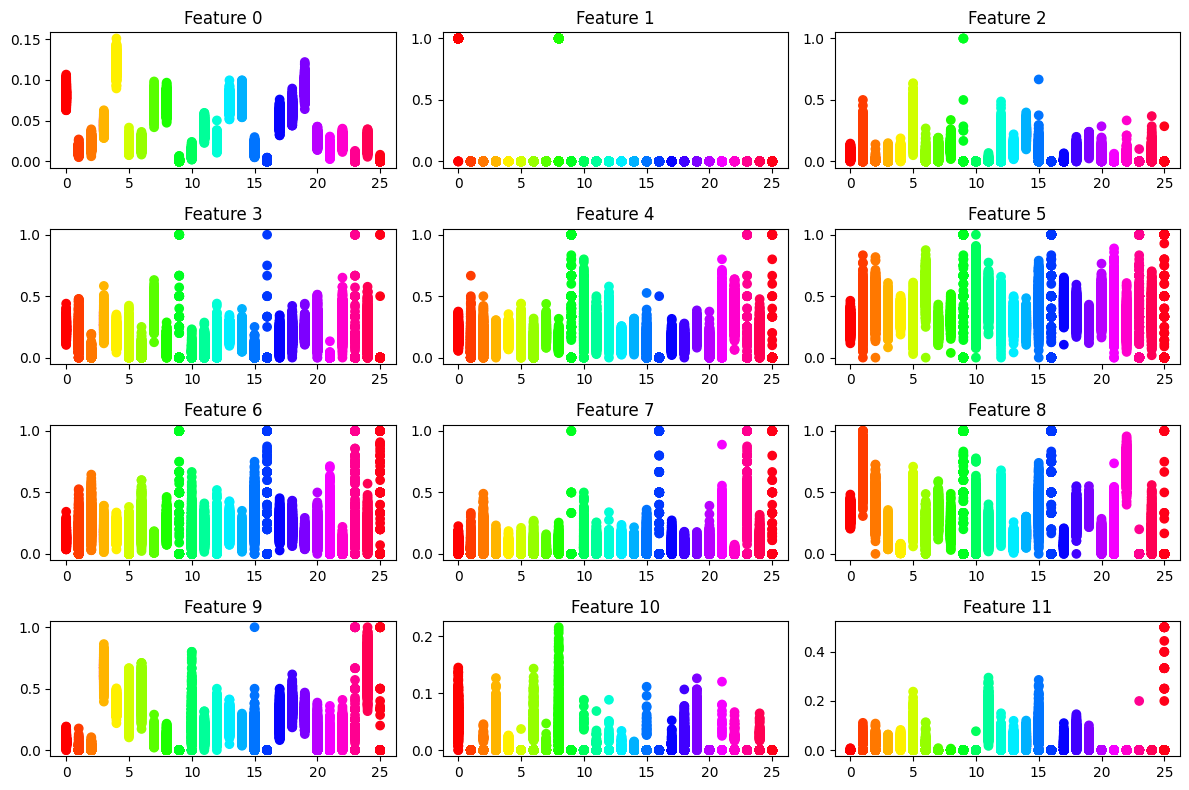

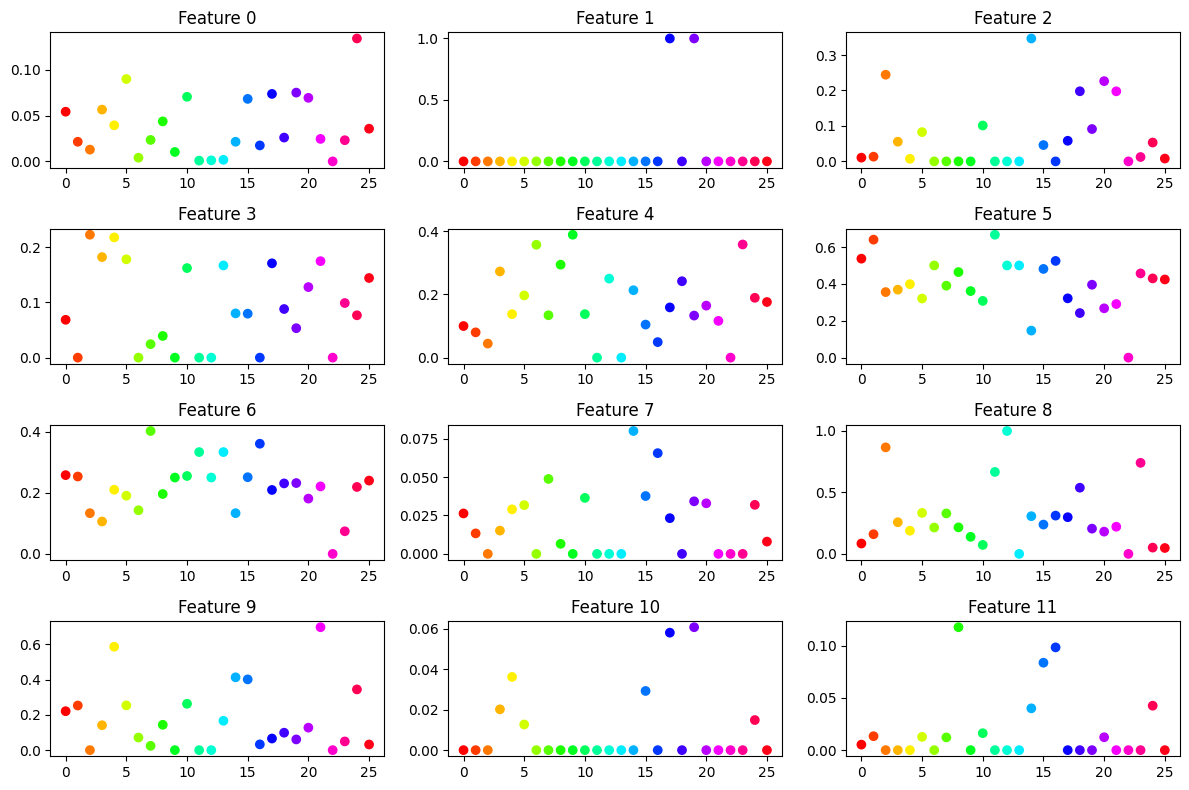


Accuracy Classification Score: 1.00
Decrypted Ciphertext:
time was when cold seduction strove to swagger as the art of love everywhere trumpeting its feats not seeking love but sensual sweets but
this amusement delicate was worthy of that old baboon our fathers used to dote upon the lovelaces are out of date their glory with their
heels of red and long perukes hath vanished for who imposture can endure a constant harping on one tune serious endeavours to assure what
everybody long has known ever to hear the same replies and overcome antipathies which never have existed even in little maidens of thirteen
and what like menaces fatigues entreaties oaths fictitious fear epistles of six sheets or near rings tears deceptions and intrigues aunts
mothers and their scrutiny and husbands tedious amity such were the musings of eugene he in the early years of life had a deluded victim
been of error and the passions strife by daily life deteriorated awhile this beauty captivated and that no longer

In [18]:
if __name__ == "__main__":
    main()